<p align="center">
    <img src="https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/076ffad6-abf4-431b-af15-10373ba06182" align="center">
</p>

# <b>[ML] 용접기기 진동/전류 데이터 실습

**제목:** 용접 공정의 진동/전류 데이터 기반 이상감지<br>
**Description:** 신호 데이터를 이용한 머신러닝 기반의 이상감지(outlier detection) 모형 개발 실습<br>

- 시각화
- Outlier Detection - MDC, KDE, Isolation Forest
- Clustering - K-Means, DBSCAN, AHC

https://www.kamp-ai.kr/aidataDetail?DATASET_SEQ=5

In [1]:
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import *
from imblearn.under_sampling import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# 데이터셋 불러오기
df = pd.read_excel('dataset/Welding Data Set_01.xlsx', sheet_name='Raw data', index_col='idx')

In [3]:
df.head()

,Machine_Name,Item No,working time,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
idx,,,,,,,,,
1,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.33,14.57,2.701,72.0
2,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.57,2.701,72.0
3,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,71.0
4,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,72.0
5,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.56,2.704,72.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11939 entries, 1 to 669
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Machine_Name      11939 non-null  object        
 1   Item No           11939 non-null  object        
 2   working time      11939 non-null  datetime64[ns]
 3   Thickness 1(mm)   11939 non-null  float64       
 4   Thickness 2(mm)   11939 non-null  float64       
 5   weld force(bar)   11939 non-null  float64       
 6   weld current(kA)  11939 non-null  float64       
 7   weld Voltage(v)   11939 non-null  float64       
 8   weld time(ms)     11939 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 932.7+ KB


In [5]:
df.isna().sum()

Machine_Name        0
Item No             0
working time        0
Thickness 1(mm)     0
Thickness 2(mm)     0
weld force(bar)     0
weld current(kA)    0
weld Voltage(v)     0
weld time(ms)       0
dtype: int64

In [6]:
df['working time'].unique()

<DatetimeArray>
['2020-03-24 00:00:00', '2020-03-25 00:00:00', '2020-03-26 00:00:00',
 '2020-03-27 00:00:00', '2020-03-30 00:00:00', '2020-03-31 00:00:00',
 '2020-04-02 00:00:00', '2020-04-03 00:00:00', '2020-04-07 00:00:00']
Length: 9, dtype: datetime64[ns]

In [7]:
# df['working time'] = pd.to_datetime(df['working time'], format='%Y-%m-%d')

In [8]:
sheet_2 = pd.read_excel('dataset/Welding Data Set_01.xlsx', sheet_name='result')

In [9]:
sheet_3 = result = pd.read_excel('dataset/Welding Data Set_01.xlsx', sheet_name='data set')

In [10]:
df.describe()

,working time,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
count,11939,11939.0,11939.0,11939.000000,11939.000000,11939.000000,11939.000000
mean,2020-03-29 10:49:44.571572224,0.7,0.7,2.787925,14.711208,2.704223,71.724123
min,2020-03-24 00:00:00,0.7,0.7,1.740000,14.520000,2.464000,70.000000
25%,2020-03-26 00:00:00,0.7,0.7,2.310000,14.610000,2.699000,71.000000
50%,2020-03-30 00:00:00,0.7,0.7,2.340000,14.730000,2.702000,72.000000
75%,2020-04-02 00:00:00,0.7,0.7,2.370000,14.750000,2.706000,72.000000
max,2020-04-07 00:00:00,0.7,0.7,10.540000,15.070000,2.861000,73.000000
std,NaN,0.0,0.0,1.455966,0.099000,0.024700,0.632049


In [11]:
drop_cols = []

for col in df.columns:
    if len(df[col].unique())==1:
        drop_cols.append(col)
        
print(drop_cols)

['Machine_Name', 'Item No', 'Thickness 1(mm)', 'Thickness 2(mm)']


In [12]:
df.drop(columns=drop_cols, axis=1, inplace=True)

df.head()

,working time,weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
idx,,,,,
1,2020-03-24,2.33,14.57,2.701,72.0
2,2020-03-24,2.36,14.57,2.701,72.0
3,2020-03-24,2.37,14.54,2.703,71.0
4,2020-03-24,2.37,14.54,2.703,72.0
5,2020-03-24,2.36,14.56,2.704,72.0


In [13]:
df.columns

Index(['working time', 'weld force(bar)', 'weld current(kA)',
       'weld Voltage(v)', 'weld time(ms)'],
      dtype='object')

In [20]:
selected_cols = ['weld force(bar)', 'weld current(kA)', 'weld Voltage(v)', 'weld time(ms)']

**Correlation**

In [21]:
df[selected_cols].corr()

,weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
weld force(bar),1.000000,0.411675,0.133876,-0.005557
weld current(kA),0.411675,1.000000,0.129596,-0.020933
weld Voltage(v),0.133876,0.129596,1.000000,0.010169
weld time(ms),-0.005557,-0.020933,0.010169,1.000000


**Scatterplot Matrix**

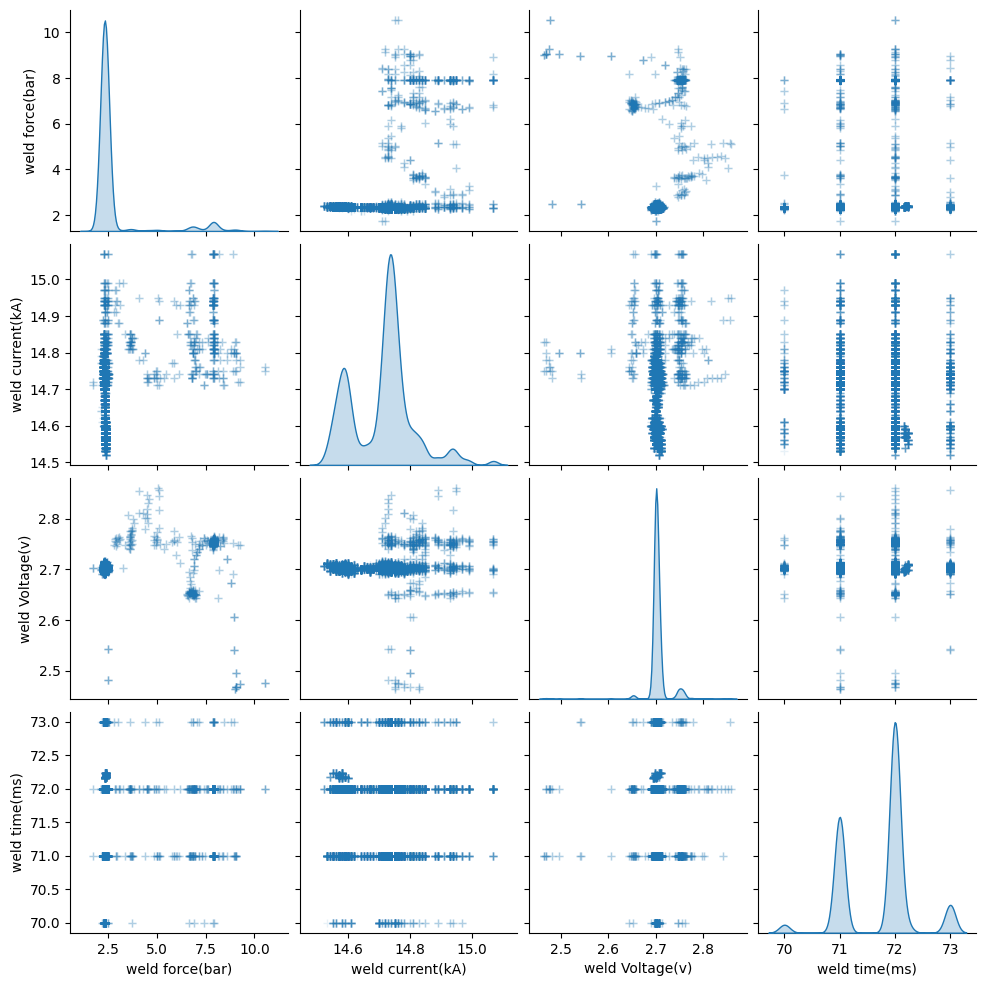

Execution time: 2.3414013385772705 seconds


In [22]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
start_time = time.time()

sns.pairplot(df[selected_cols], diag_kind='kde', plot_kws=dict(marker="+", linewidth=1, alpha=0.1))
plt.show()

end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

**Correlation Heatmap**

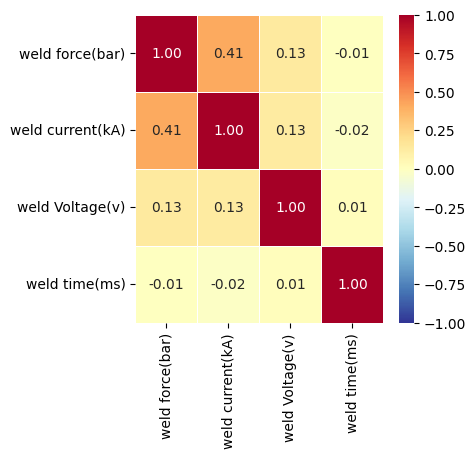

In [23]:
plt.figure(figsize=(4,4))
sns.heatmap(
    data=df[selected_cols].corr(),
    annot=True, 
    fmt = '.2f', 
    linewidths=.5, 
    cmap='RdYlBu_r', # Blue
    vmin=-1, vmax=1  # 컬러바 범위 -1 ~ 1
)
plt.show()

**Histogram**

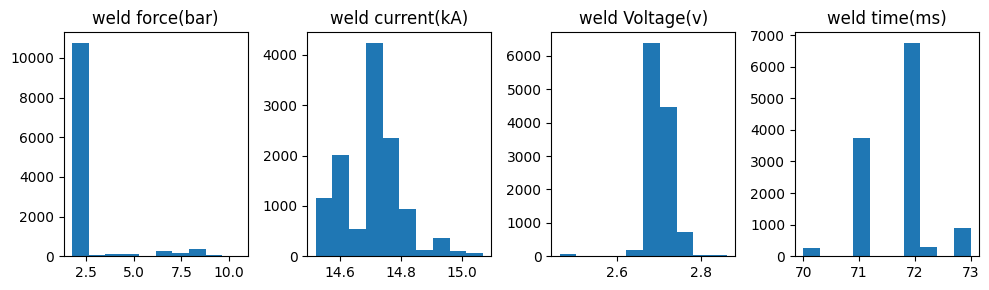

In [24]:
plt.figure(figsize=(10,3))

for i, col in enumerate(selected_cols):
    num = 141+i
    plt.subplot(num)
    plt.hist(df[col])
    # plt.xticks(rotation=45)
    plt.title(col)
    
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)    
plt.tight_layout()
plt.show()

**Boxplot**

<img src="https://miro.medium.com/max/9000/1*2c21SkzJMf3frPXPAR_gZA.png" alt="Boxplot" style="width: 600px">

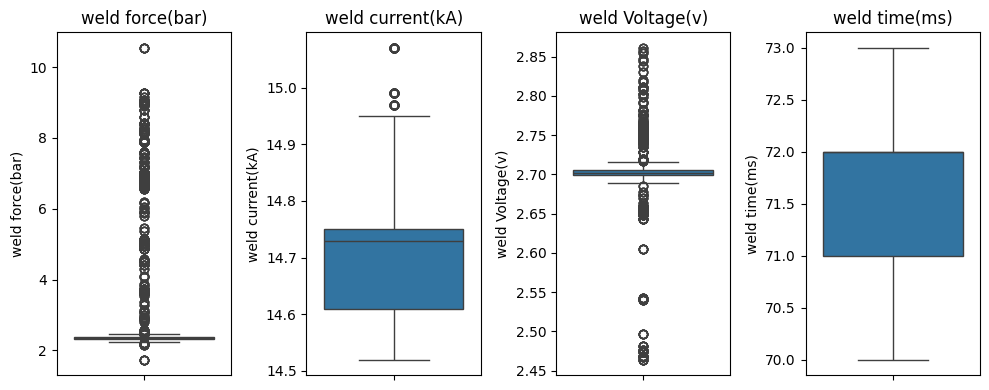

In [25]:
plt.figure(figsize=(10,4))

for i, col in enumerate(selected_cols):
    num = 141+i
    plt.subplot(num)
    sns.boxplot(data=df, y=col)
    plt.title(col)

plt.tight_layout()
plt.show()

In [27]:
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(df[selected_cols])

X_train_scaled = scaled_data[:8470]
X_test_scaled = scaled_data[8470:]

### Outlier Detection

**Mahalanobis Distance Classification**

In [28]:
def get_MD_distance(x):
    normal_cov_mat = pd.DataFrame(X_train_scaled).corr()
    dist = np.matmul(np.matmul(x, np.linalg.inv(normal_cov_mat)), np.transpose(x)) / len(x)
    return dist

In [29]:
%%time
X_train_dist = np.apply_along_axis(get_MD_distance, 1, X_train_scaled)

CPU times: total: 3.3 s
Wall time: 3.63 s


In [30]:
X_test_dist = np.apply_along_axis(get_MD_distance, 1, X_test_scaled)

In [31]:
extream_threshold = 2.0 * np.std(X_train_dist)
very_extream_threshold = 3.0 * np.std(X_train_dist)
mean_train_ = np.mean(X_train_dist)

extream_L = mean_train_ - extream_threshold
extream_U = mean_train_ + extream_threshold

very_extream_L = mean_train_ - very_extream_threshold
very_extream_U = mean_train_ + very_extream_threshold

print("mean_MD_train : " + str(mean_train_) + '\n' )
print("extream_threshold : " + str(extream_L) + " ~ " + str(extream_U)) # 95%
print("very_extream_threshold : " + str(very_extream_L) + " ~ " + str(very_extream_U)) # 99.7%

mean_MD_train : 1.02944233170947

extream_threshold : -3.776755429164864 ~ 5.835640092583804
very_extream_threshold : -6.179854309602032 ~ 8.238738973020972


In [32]:
y_pred_MDC = X_test_dist.copy()

In [33]:
for i in range(len(y_pred_MDC)):
    if (y_pred_MDC[i]>extream_U) or (y_pred_MDC[i]<extream_L):
        y_pred_MDC[i] = 1
    else:
        y_pred_MDC[i] = 0

In [34]:
np.unique(y_pred_MDC, return_counts=True)

(array([0., 1.]), array([3432,   37], dtype=int64))

**KDE**

PCA

In [35]:
from sklearn.decomposition import PCA

In [36]:
KDE_PCA_train = PCA(n_components=2)

In [37]:
PCA_X_train = KDE_PCA_train.fit_transform(X_train_scaled)
PCA_X_test = KDE_PCA_train.fit_transform(X_test_scaled)
# PCA_X_train_Ab = KDE_PCA_train.transform(X_train_Ab)

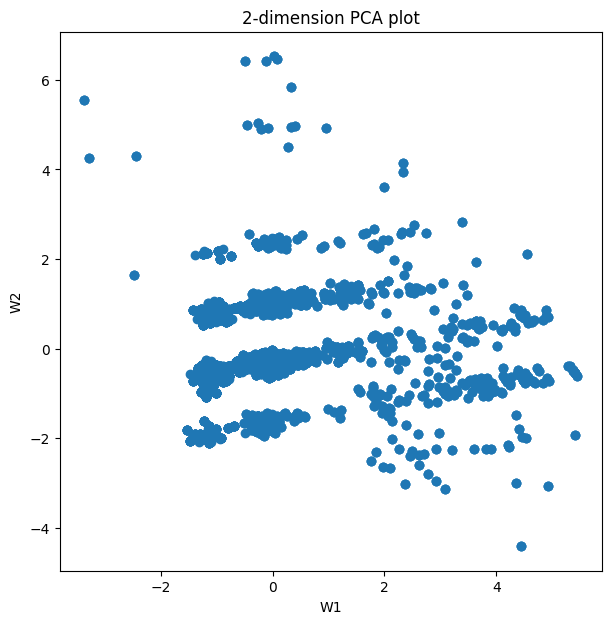

In [38]:
plt.figure(figsize=(7, 7))
# plt.rcParams.update({'font.size': 22})
plt.title("2-dimension PCA plot")
# plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['axes.grid'] = True 

plt.scatter(PCA_X_train[:,0], PCA_X_train[:,1])
plt.ylabel("W2")
plt.xlabel("W1")

plt.show()

In [39]:
from sklearn.neighbors import KernelDensity

In [40]:
n=30
bandwidth = 1.06*np.std(PCA_X_train)*((1/n)**(1/5))

In [41]:
PCA_KDE_model = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
PCA_KDE_model.fit(PCA_X_train)

KernelDensity(bandwidth=0.6059350405201303)

In [42]:
y_pred_PCA_KDE = PCA_KDE_model.score_samples(PCA_X_train)

In [43]:
normal_KDE = np.exp(y_pred_PCA_KDE)

In [44]:
print(np.mean(normal_KDE))
print(np.std(normal_KDE))

print(np.mean(normal_KDE)-2*np.std(normal_KDE) )

0.10217202727156341
0.0559023661462346
-0.009632705020905796


In [45]:
# y_pred_PCA_KDE_Ab = PCA_KDE_model.score_samples(PCA_X_train_Ab)

In [46]:
y_pred_KDE = PCA_KDE_model.score_samples(PCA_X_test)

In [47]:
for i in range (len(y_pred_KDE)):
    if np.exp(y_pred_KDE[i])>np.mean(normal_KDE)-2*np.std(normal_KDE):
        y_pred_KDE[i] = 0
    else:
        y_pred_KDE[i] = 1

In [48]:
y_pred_KDE

array([0., 0., 0., ..., 0., 0., 0.])

**Isolatin Forest**<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [49]:
from sklearn.ensemble import IsolationForest

IF_model = IsolationForest(n_estimators=50, random_state=10)
IF_model.fit(X_train_scaled)

IsolationForest(n_estimators=50, random_state=10)

In [50]:
y_pred_IF = IF_model.predict(X_test_scaled)
for i in range (len(y_pred_IF)):
    if y_pred_IF[i]==1:
        y_pred_IF[i]=0
    else:
        y_pred_IF[i]=1

print(y_pred_IF)

[0 0 0 ... 0 1 1]


In [51]:
np.unique(y_pred_IF, return_counts=True)

(array([0, 1]), array([2969,  500], dtype=int64))

## Clustering

In [52]:
sheet_2.head() # 불량 3종류, 정상 = 총 4종류

,idx,Machine_Name,Item No,working time,defect,defect type,Unnamed: 6
0,1,Spot-01,65235-25800,2020-03-24,2,1,파임불량
1,2,Spot-01,65235-25800,2020-03-24,1,2,용접부족
2,3,Spot-01,65235-25800,2020-03-24,1,3,크랙발생
3,4,Spot-01,65235-25800,2020-03-25,3,1,NaN
4,5,Spot-01,65235-25800,2020-03-25,2,2,NaN


In [53]:
sheet_2.defect.sum()

39

- 총 4가지의 상태(정상, 파임불량, 용접부족, 크랙발생)가 존재함
- 불량 총 개수: 39개

**K-Means**

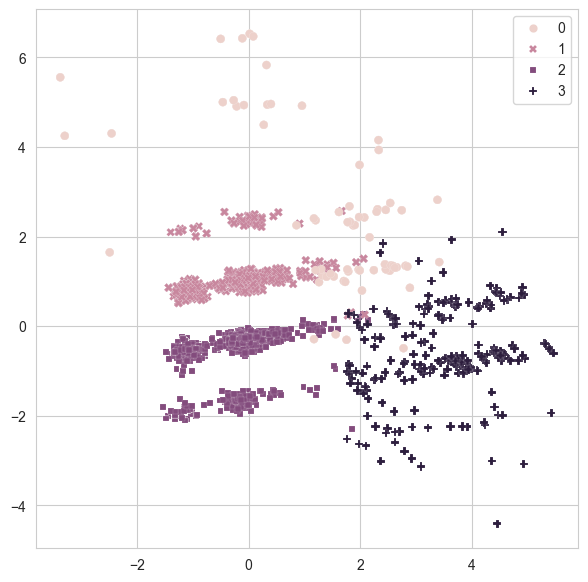

In [54]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X_train_scaled)

plt.figure(figsize=(7, 7))
sns.set_style('whitegrid')
sns.scatterplot(x=PCA_X_train[:,0], y=PCA_X_train[:,1], hue=kmeans.labels_, linewidth=0.1, style=kmeans.labels_)
plt.show()

**DBSCAN**

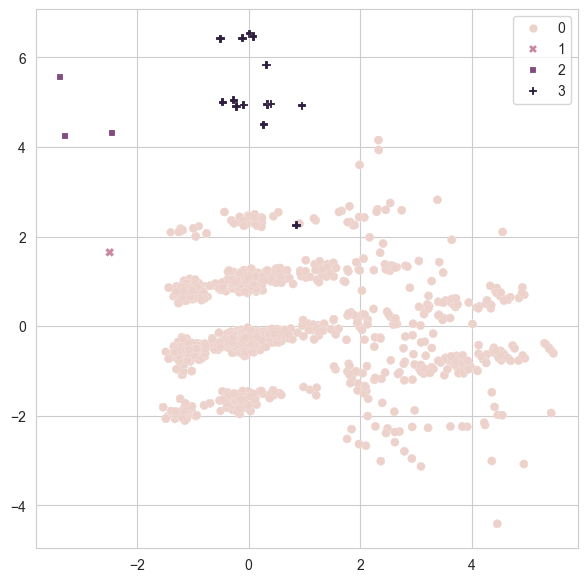

In [55]:
from sklearn.cluster import DBSCAN

# eps : 클러스터를 구성하는 최소의 거리
# min_samples : 클러스터를 구성하기 위해 필요한 최소 데이터 포인트 수
dbscan = DBSCAN(eps=2.5, min_samples=2).fit(X_train_scaled)

plt.figure(figsize=(7, 7))
sns.set_style('whitegrid')
sns.scatterplot(x=PCA_X_train[:,0], y=PCA_X_train[:,1], hue=dbscan.labels_, linewidth=0.1, style=dbscan.labels_)
plt.show()

**Agglomerative Hierarchical Clustering(AHC)**

In [57]:
# plt.figure(figsize=(7, 7))
# sns.set_style('whitegrid')
# sns.scatterplot(x=PCA_X_train[:,0], y=PCA_X_train[:,1], hue=ahc.labels_, linewidth=0.1, style=ahc.labels_)
# plt.show()

In [58]:
ahc.labels_

array([6295, 8469, 4847, ...,    4,    1,    0], dtype=int64)

In [59]:
ahc.distances_

array([  0.        ,   0.        ,   0.        , ..., 103.89763631,
       105.59766559, 140.71640112])

In [60]:
ahc.children_

array([[    1,   378],
       [  142,   143],
       [ 2187,  8471],
       ...,
       [16932, 16935],
       [16934, 16936],
       [16931, 16937]], dtype=int64)

In [61]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

ahc = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean').fit(X_train_scaled)

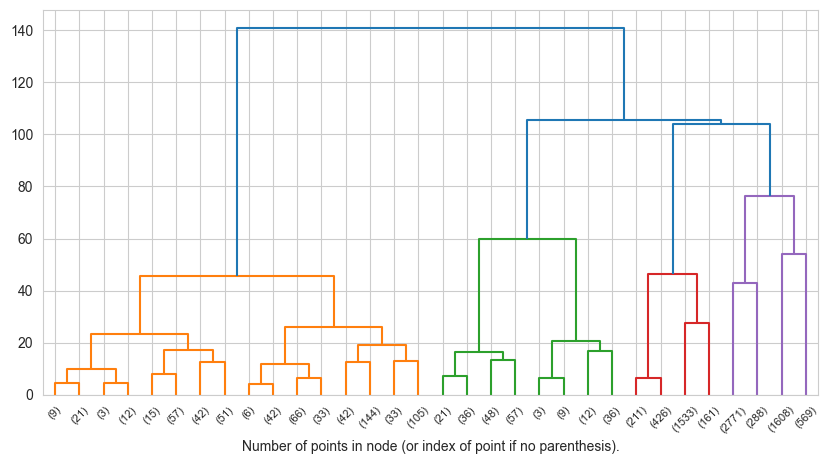

In [62]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.figure(figsize=(10, 5))
plot_dendrogram(ahc, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
# from scipy.cluster.hierarchy import dendrogram, linkage

# Z = linkage(X_train_scaled, method="ward")

# fig = plt.figure(figsize=(10, 6))
# dendrogram(Z, labels=range(X_train_scaled.shape[0]))
# plt.title('Hierarchical Clustering Dendrogram (ward linkage)')
# plt.show()